In [65]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
import viz
from style import *
import analyze_helper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare all models

In [66]:
out_dir = 'results/outcome=y_thresh'
results = analyze_helper.load_results(out_dir)

**look at prediction metrics**

In [7]:
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values('accuracy', ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

,accuracy,balanced_accuracy,f1,precision,recall,roc_auc
model_type,,,,,,
mlp2_11_none,0.676,0.659,0.768,0.859,0.707,0.71
mlp2_9_none,0.675,0.655,0.765,0.845,0.712,0.715
svm_35_none,0.674,0.613,0.771,0.698,0.88,0.613
svm_23_none,0.673,0.661,0.771,0.879,0.699,0.614
svm_9_none,0.67,0.658,0.769,0.877,0.698,0.613
svm_11_none,0.668,0.652,0.767,0.873,0.697,0.61
logistic_4_none,0.667,0.664,0.766,0.873,0.703,0.7
svm_4_none,0.667,0.671,0.775,0.918,0.682,0.591
mlp2_4_none,0.664,0.65,0.764,0.871,0.695,0.707


**look at feat importances**

In [11]:
r = results
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])
r = r.sort_values('accuracy', ascending=False)
keys = [k for k in r if '_f' in k]
keys_remapped = {k: k.replace('_f', '') for k in keys}
r = r[keys].rename(columns=keys_remapped)
# r = r.sort_values('lifetime')
# r = r[r.index.str.contains('39')]
# r = r[r.index.str.contains('11')]
r = r.rename(columns={'mean_square_displacement': 'msd', 'total_displacement': 'td'})

r = r[r.index.str.contains('11')]
# r = r[r2.index.str.contains('ros')]
r = r[r.index.str.contains('none')]
r = r[[k for k in r if not 'std' in k]]


def rank(r):
    '''Rank feature importances appropriately
    '''
    r = r.abs()
    r = r.rank(axis=1, ascending=False, method='min')
    return r
# 
r = rank(r)
r = r.reindex(r.mean().sort_values(ascending=True).index, axis=1) # sort cols by mean rank
idxs = r.index
r.insert(0, 'acc', results.loc[idxs]['accuracy'])

subset = list(r.keys())
subset.remove('acc')
r.fillna(0).style.background_gradient(cmap='viridis_r', axis=1, subset=subset) # rows differently colored

,acc,fall,lifetime,msd,rise,td,X_max,X_min,X_mean,max_diff,min_diff,nmf_0,nmf_10,nmf_11,nmf_1,nmf_2,nmf_3,nmf_4,nmf_5,nmf_6,nmf_7,nmf_8,nmf_9,sc_0,sc_10,sc_11,sc_1,sc_2,sc_3,sc_4,sc_5,sc_6,sc_7,sc_8,sc_9
model_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mlp2_11_none,0.676,1,2,6,9,3,7,8,3,3,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
svm_11_none,0.668,1,2,8,5,6,3,4,6,10,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
logistic_11_none,0.662,7,1,6,4,8,2,2,5,9,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
rf_11_none,0.66,1,2,4,3,4,8,6,10,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
gb_11_none,0.633,1,5,1,7,5,3,4,9,10,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dt_11_none,0.575,1,3,4,2,5,10,9,8,7,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# analyze model predictions

In [ ]:
df = data_tracks.get_data()
n = df.shape[0]

# make logistic data
# feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement']
# feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 'rise', 'fall']
# feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
#               'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff']
scs = [f'sc_{i}' for i in range(12)]
feat_names = ['X_max', 'lifetime', 'total_displacement', 'mean_square_displacement', 
              'rise', 'fall', 'X_std', 'X_min', 'X_mean', 'max_diff', 'min_diff'] + scs
X = df[feat_names]

# normalize and store
X_mean = X.mean()
X_std = X.std()
norms = {
    feat_names[i]: {'mu': X_mean[i], 'std': X_std[i]} for i in range(len(feat_names))
}
X = (X - X_mean) / X_std
y = df['y_thresh'].values


# split testing data based on cell num
idxs_test = df.cell_num.isin([6])
X_test, Y_test = X[idxs_test], y[idxs_test]
X_traces_test = df.X[idxs_test]

### look at single model

In [68]:
# results = pkl.load(open('results/classify_outcome=y_consec_sig/rf_ros_11.pkl', 'rb'))
results_individual = pkl.load(open('results/outcome=y_thresh/mlp2_11_none.pkl', 'rb'))
preds, preds_proba = analyze_helper.analyze_individual_results(results_individual, X_test, Y_test, 
                                                print_results=False, plot_results=False)

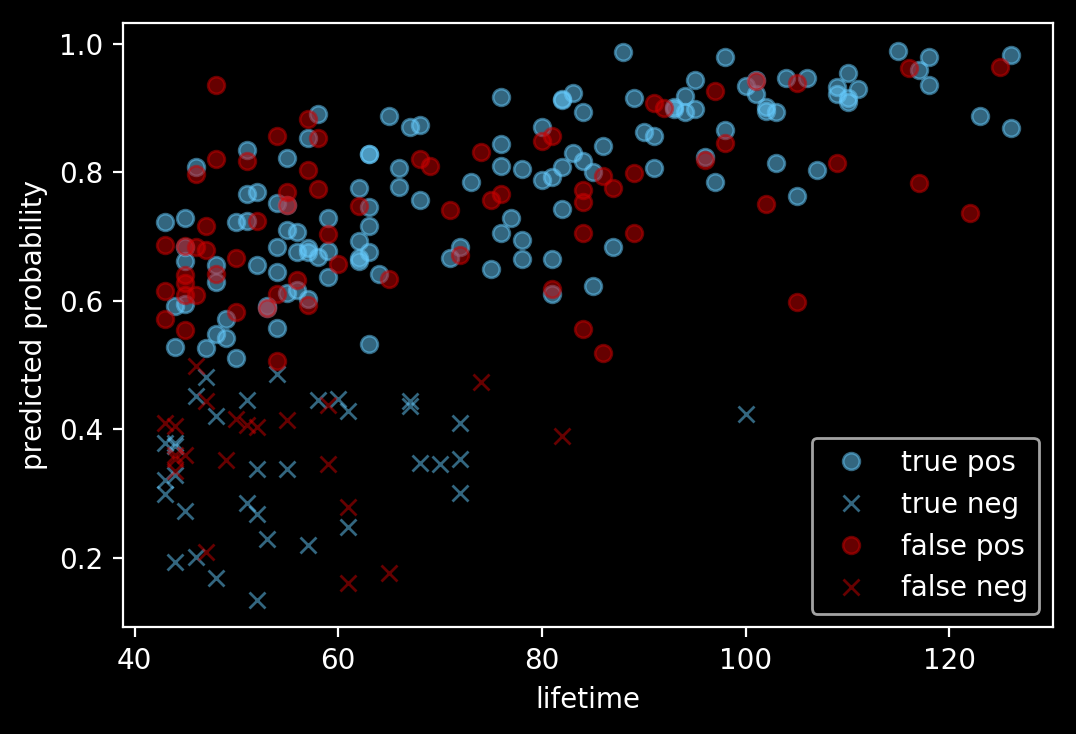

In [69]:
viz.viz_errs_lifetime(X_test, preds, preds_proba, Y_test, norms)

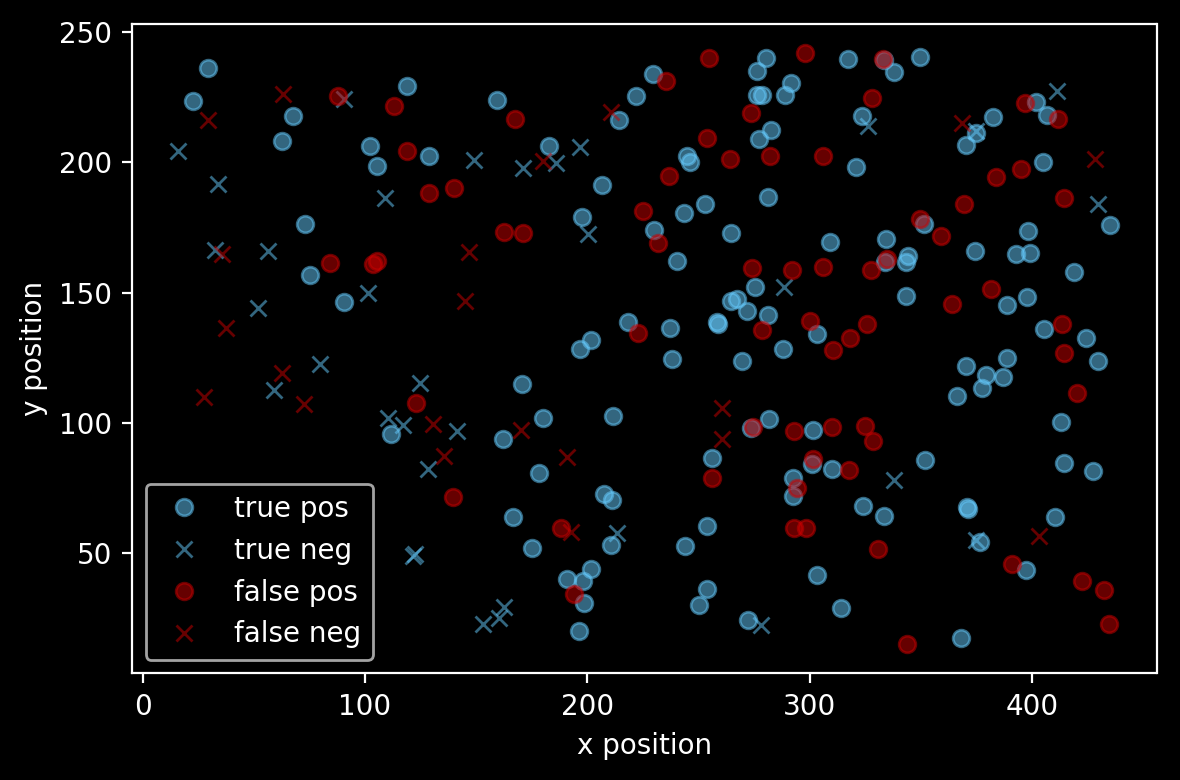

In [64]:
viz.viz_errs_spatially(df, idxs_test, preds, Y_test)

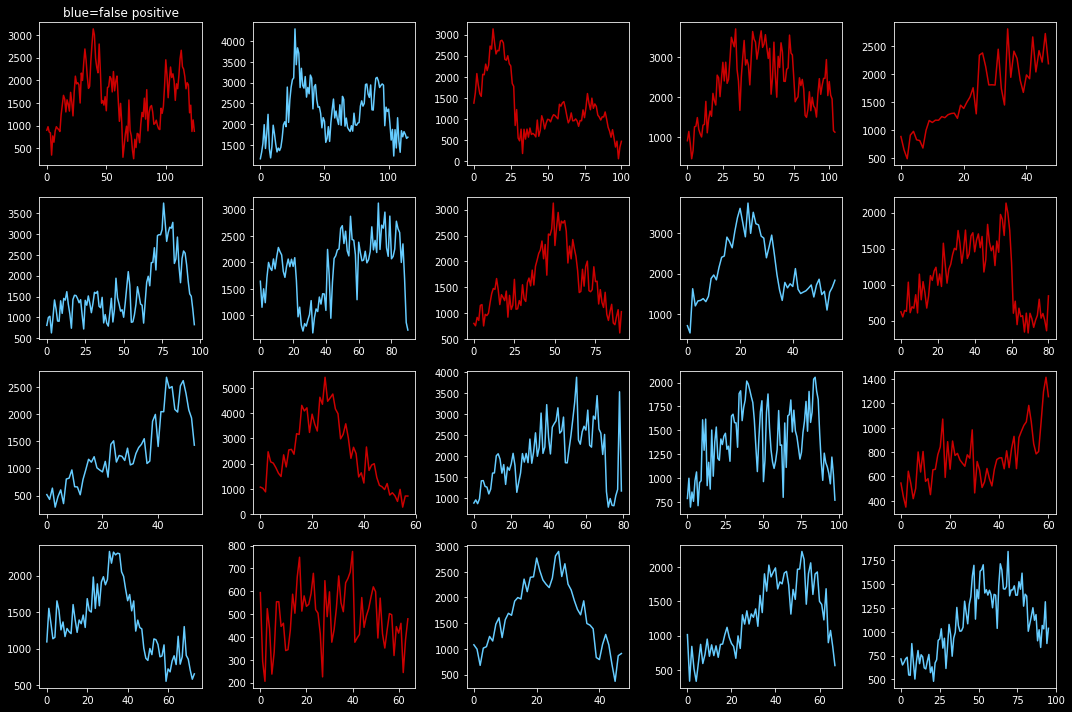

In [63]:
viz.viz_biggest_errs(X_traces_test, Y_test, preds, preds_proba)    